In [1]:
# VictimDet: Disaster Victim Detection Training on Kaggle


import os
import sys
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import yaml
import requests
import zipfile
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import shutil


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 15.9 GB


In [7]:

# =============================================================================
# STEP 1: Setup and Installation
# =============================================================================

def setup_environment():
    """Setup the training environment"""
    # Clone YOLOv5 (required for VictimDet)
    if not os.path.exists('/kaggle/working/yolov5'):
        os.system('git clone https://github.com/ultralytics/yolov5.git /kaggle/working/yolov5')
    
    # Install requirements
    os.system('pip install -q -r /kaggle/working/yolov5/requirements.txt')
    
    # Clone VictimDet repository
    if not os.path.exists('/kaggle/working/VictimDet'):
        os.system('git clone https://github.com/noahzn/VictimDet.git /kaggle/working/VictimDet')
    
    # Add paths to system
    sys.path.append('/kaggle/working/yolov5')
    sys.path.append('/kaggle/working/VictimDet')
    
    print("Environment setup complete!")

In [8]:

# =============================================================================
# STEP 2: Data Download and Preparation
# =============================================================================

def prepare_victimdet_data(train_split=0.7, val_split=0.2, test_split=0.1):
    """Prepare VictimDet data by splitting composite dataset into train/val/test"""
    import shutil
    from sklearn.model_selection import train_test_split
    
    # Source paths
    source_images = '/kaggle/input/victim-data/victim_data/images/composite'
    source_labels = '/kaggle/input/victim-data/victim_data/labels/composite'
    
    # Destination paths
    dest_base = '/kaggle/working/dataset'
    
    # Create directory structure
    for split in ['train', 'val', 'test']:
        os.makedirs(f'{dest_base}/images/{split}', exist_ok=True)
        os.makedirs(f'{dest_base}/labels/{split}', exist_ok=True)
    
    # Get all image files
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
        image_files.extend(Path(source_images).glob(ext))
    
    # Sort for reproducibility
    image_files = sorted([f.name for f in image_files])
    
    print(f"Found {len(image_files)} images in composite dataset")
    
    # Verify train+val+test = 1.0
    assert abs(train_split + val_split + test_split - 1.0) < 1e-6, "Splits must sum to 1.0"
    
    # First split: separate test set
    train_val_files, test_files = train_test_split(
        image_files, 
        test_size=test_split, 
        random_state=42,
        shuffle=True
    )
    
    # Second split: separate train and val from remaining data
    val_size_adjusted = val_split / (train_split + val_split)
    train_files, val_files = train_test_split(
        train_val_files,
        test_size=val_size_adjusted,
        random_state=42,
        shuffle=True
    )
    
    print(f"Data split:")
    print(f"  Train: {len(train_files)} images ({len(train_files)/len(image_files)*100:.1f}%)")
    print(f"  Val:   {len(val_files)} images ({len(val_files)/len(image_files)*100:.1f}%)")
    print(f"  Test:  {len(test_files)} images ({len(test_files)/len(image_files)*100:.1f}%)")
    
    # Copy files to respective directories
    def copy_files(file_list, split_name):
        copied_images = 0
        copied_labels = 0
        
        for filename in tqdm(file_list, desc=f"Copying {split_name} files"):
            # Copy image
            src_img = os.path.join(source_images, filename)
            dst_img = os.path.join(dest_base, 'images', split_name, filename)
            if os.path.exists(src_img):
                shutil.copy2(src_img, dst_img)
                copied_images += 1
            
            # Copy corresponding label file
            label_filename = os.path.splitext(filename)[0] + '.txt'
            src_label = os.path.join(source_labels, label_filename)
            dst_label = os.path.join(dest_base, 'labels', split_name, label_filename)
            if os.path.exists(src_label):
                shutil.copy2(src_label, dst_label)
                copied_labels += 1
        
        print(f"  {split_name}: Copied {copied_images} images, {copied_labels} labels")
        return copied_images, copied_labels
    
    # Copy files for each split
    train_img, train_lbl = copy_files(train_files, 'train')
    val_img, val_lbl = copy_files(val_files, 'val')
    test_img, test_lbl = copy_files(test_files, 'test')
    
    # Summary
    total_images = train_img + val_img + test_img
    total_labels = train_lbl + val_lbl + test_lbl
    
    print(f"\nDataset preparation complete!")
    print(f"Total images copied: {total_images}")
    print(f"Total labels copied: {total_labels}")
    
    if total_labels < total_images:
        print(f"Warning: {total_images - total_labels} images are missing corresponding labels")
    
    return dest_base

def create_victimdet_yaml(dataset_path='/kaggle/working/dataset'):
    """Create YOLO dataset configuration file"""
    config = {
        'train': f'{dataset_path}/images/train',
        'val': f'{dataset_path}/images/val', 
        'test': f'{dataset_path}/images/test',
        'nc': 1,  # number of classes
        'names': ['victim']  # class names
    }
    
    yaml_path = f'{dataset_path}/victimdet.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    
    print(f"Dataset configuration created at: {yaml_path}")
    print("Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    
    return yaml_path

def verify_data_split(dataset_path='/kaggle/working/dataset'):
    """Verify the data split and show statistics"""
    splits = ['train', 'val', 'test']
    
    print("\nDataset verification:")
    print("-" * 50)
    
    for split in splits:
        img_dir = f'{dataset_path}/images/{split}'
        lbl_dir = f'{dataset_path}/labels/{split}'
        
        # Count files
        img_count = len(list(Path(img_dir).glob('*'))) if os.path.exists(img_dir) else 0
        lbl_count = len(list(Path(lbl_dir).glob('*.txt'))) if os.path.exists(lbl_dir) else 0
        
        print(f"{split.upper():5}: {img_count:4} images, {lbl_count:4} labels")
        
        # Sample label file analysis
        if lbl_count > 0:
            sample_label = list(Path(lbl_dir).glob('*.txt'))[0]
            with open(sample_label, 'r') as f:
                lines = f.readlines()
                print(f"       Sample label has {len(lines)} annotations")
    
    print("-" * 50)


In [9]:
class VictimDetDataset(Dataset):
    """Custom dataset for victim detection"""
    
    def __init__(self, images_dir, labels_dir, transform=None, img_size=640):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.transform = transform
        self.img_size = img_size
        
        # Get all image files
        self.image_files = list(self.images_dir.glob('*.jpg')) + \
                          list(self.images_dir.glob('*.png'))
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load labels
        label_path = self.labels_dir / (img_path.stem + '.txt')
        boxes = []
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    boxes.append([class_id, x_center, y_center, width, height])
        
        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        return image, torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 5))

def get_training_transforms(img_size=640):
    """Get augmentation transforms for training"""
    return A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.RandomRotate90(p=0.2),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=0.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.RandomFog(p=0.1),
        A.RandomSunFlare(p=0.1),
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_validation_transforms(img_size=640):
    """Get transforms for validation"""
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])


In [10]:

# =============================================================================
# STEP 4: Model Training Setup
# =============================================================================

def train_victimdet_model(data_yaml_path, epochs=100, img_size=640, batch_size=16):
    """Train VictimDet model using YOLOv5"""
    
    # Training command
    train_cmd = f"""
    cd /kaggle/working/yolov5 && python train.py \
        --img {img_size} \
        --batch {batch_size} \
        --epochs {epochs} \
        --data {data_yaml_path} \
        --weights yolov5s.pt \
        --name victimdet_experiment \
        --cache \
        --device {device.index if device.type == 'cuda' else 'cpu'} \
        --project /kaggle/working/runs \
        --exist-ok
    """
    
    print("Starting VictimDet training...")
    print(f"Command: {train_cmd}")
    
    # Execute training
    os.system(train_cmd)

def train_with_custom_loop():
    """Alternative training with custom training loop"""
    # Load YOLOv5 model
    from models.yolo import Model
    from utils.general import check_dataset
    from utils.torch_utils import ModelEMA
    
    # Initialize model
    model = Model('/kaggle/working/yolov5/models/yolov5s.yaml', ch=3, nc=1)
    model.to(device)
    
    # Setup optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
    
    # Training loop would go here...
    print("Custom training loop setup complete")


In [11]:

# =============================================================================
# STEP 5: Evaluation and Visualization
# =============================================================================

def evaluate_model(model_path, test_data_path):
    """Evaluate trained model"""
    eval_cmd = f"""
    cd /kaggle/working/yolov5 && python val.py \
        --weights {model_path} \
        --data {test_data_path} \
        --img 640 \
        --device {device.index if device.type == 'cuda' else 'cpu'} \
        --project /kaggle/working/runs \
        --name evaluation
    """
    
    os.system(eval_cmd)

def visualize_predictions(model_path, image_path, save_path=None):
    """Visualize model predictions"""
    detect_cmd = f"""
    cd /kaggle/working/yolov5 && python detect.py \
        --weights {model_path} \
        --source {image_path} \
        --img 640 \
        --conf 0.25 \
        --device {device.index if device.type == 'cuda' else 'cpu'} \
        --project /kaggle/working/runs \
        --name detection \
        --save-txt \
        --save-conf
    """
    
    os.system(detect_cmd)

def plot_training_results(runs_dir='/kaggle/working/runs/train/victimdet_experiment'):
    """Plot training metrics"""
    results_path = Path(runs_dir) / 'results.csv'
    
    if results_path.exists():
        df = pd.read_csv(results_path)
        df.columns = df.columns.str.strip()  # Remove whitespace
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot losses
        axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Box Loss')
        axes[0, 0].plot(df['epoch'], df['train/obj_loss'], label='Obj Loss')
        axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='Cls Loss')
        axes[0, 0].set_title('Training Losses')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Plot mAP
        axes[0, 1].plot(df['epoch'], df['metrics/mAP_0.5'], label='mAP@0.5')
        axes[0, 1].plot(df['epoch'], df['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
        axes[0, 1].set_title('Mean Average Precision')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Plot Precision/Recall
        axes[1, 0].plot(df['epoch'], df['metrics/precision'], label='Precision')
        axes[1, 0].plot(df['epoch'], df['metrics/recall'], label='Recall')
        axes[1, 0].set_title('Precision & Recall')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        # Plot F1 Score
        axes[1, 1].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
        axes[1, 1].plot(df['epoch'], df['val/obj_loss'], label='Val Obj Loss')
        axes[1, 1].set_title('Validation Losses')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.savefig('/kaggle/working/training_results.png', dpi=300, bbox_inches='tight')
        plt.show()


In [ ]:


# =============================================================================
# STEP 6: Main Execution
# =============================================================================

def main():
    """Main training pipeline"""
    print("=== VictimDet Training Pipeline ===")
    
    # 1. Setup environment
    print("\n1. Setting up environment...")
    setup_environment()
    
    # 2. Prepare and split dataset
    print("\n2. Preparing dataset from composite folder...")
    dataset_path = prepare_victimdet_data(train_split=0.7, val_split=0.2, test_split=0.1)
    
    # 3. Create YAML configuration
    print("\n3. Creating dataset configuration...")
    data_yaml_path = create_victimdet_yaml(dataset_path)
    
    # 4. Verify data split
    print("\n4. Verifying data split...")
    verify_data_split(dataset_path)
    
    # 5. Start training
    print("\n5. Training model...")
    print("Starting VictimDet training with your dataset...")
    train_victimdet_model(data_yaml_path, epochs=100, batch_size=16)
    
    # 6. Evaluation
    print("\n6. Model evaluation...")
    evaluate_model('/kaggle/working/runs/train/victimdet_experiment/weights/best.pt', data_yaml_path)
    
    # 7. Visualization
    print("\n7. Results visualization...")
    plot_training_results()

# Additional utility functions
def download_sample_data():
    """Download sample disaster images for testing (placeholder)"""
    print("For sample disaster detection datasets, check:")
    print("- RescueNet: Hurricane damage assessment dataset")
    print("- FloodNet: Flood scene understanding dataset") 
    print("- xBD: Building damage assessment dataset")
    print("These can be adapted for victim detection tasks")

def hyperparameter_tuning():
    """Hyperparameter tuning suggestions"""
    print("Recommended hyperparameters for VictimDet:")
    print("- Image size: 640x640 (balance between speed and accuracy)")
    print("- Batch size: 16-32 (depending on GPU memory)")
    print("- Learning rate: 0.01 (with cosine annealing)")
    print("- Epochs: 100-300 (with early stopping)")
    print("- Augmentations: Heavy (due to limited real data)")
    print("- Confidence threshold: 0.25-0.4 for detection")

if __name__ == "__main__":
    main()

# =============================================================================
# USAGE INSTRUCTIONS
# =============================================================================
"""
STEP-BY-STEP USAGE:

1. Upload this notebook to Kaggle
2. Upload your victim-data dataset as shown in your directory structure
3. Enable GPU accelerator (Settings > Accelerator > GPU)
4. Run the setup cells to install dependencies
5. Run main() to automatically split data and start training
6. Monitor training progress and adjust hyperparameters as needed
7. Evaluate the model and visualize results

AUTOMATIC DATA SPLITTING:
The code will automatically split your composite dataset:
- 70% for training
- 20% for validation  
- 10% for testing

You can modify the splits by calling:
prepare_victimdet_data(train_split=0.8, val_split=0.15, test_split=0.05)

DATASET STRUCTURE (Input):
/kaggle/input/victim-data/victim_data/
├── images/
│   └── composite/     # All your images here
└── labels/
    └── composite/     # All your labels here

DATASET STRUCTURE (Output after splitting):
/kaggle/working/dataset/
├── images/
│   ├── train/        # 70% of images
│   ├── val/          # 20% of images
│   └── test/         # 10% of images
└── labels/
    ├── train/        # Corresponding training labels
    ├── val/          # Corresponding validation labels
    └── test/         # Corresponding test labels

LABEL FORMAT (YOLO):
class_id x_center y_center width height
(normalized coordinates between 0-1)

For victim detection: class_id = 0 (victim)

MANUAL USAGE:
If you want to run steps individually:

# Split the data
dataset_path = prepare_victimdet_data()

# Create config
yaml_path = create_victimdet_yaml(dataset_path)

# Verify split
verify_data_split(dataset_path)

# Train model
train_victimdet_model(yaml_path, epochs=100, batch_size=16)
"""

=== VictimDet Training Pipeline ===

1. Setting up environment...


Cloning into '/kaggle/working/yolov5'...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.2 MB/s eta 0:00:00


Cloning into '/kaggle/working/VictimDet'...


Environment setup complete!

2. Preparing dataset from composite folder...
Found 3009 images in composite dataset
Data split:
  Train: 2106 images (70.0%)
  Val:   602 images (20.0%)
  Test:  301 images (10.0%)


Copying train files: 100%|██████████| 2106/2106 [00:22<00:00, 93.07it/s] 


  train: Copied 2106 images, 2106 labels


Copying val files: 100%|██████████| 602/602 [00:06<00:00, 86.47it/s]


  val: Copied 602 images, 602 labels


Copying test files: 100%|██████████| 301/301 [00:03<00:00, 82.11it/s]


  test: Copied 301 images, 301 labels

Dataset preparation complete!
Total images copied: 3009
Total labels copied: 3009

3. Creating dataset configuration...
Dataset configuration created at: /kaggle/working/dataset/victimdet.yaml
Configuration:
  train: /kaggle/working/dataset/images/train
  val: /kaggle/working/dataset/images/val
  test: /kaggle/working/dataset/images/test
  nc: 1
  names: ['victim']

4. Verifying data split...

Dataset verification:
--------------------------------------------------
TRAIN: 2106 images, 2106 labels
       Sample label has 1 annotations
VAL  :  602 images,  602 labels
       Sample label has 1 annotations
TEST :  301 images,  301 labels
       Sample label has 1 annotations
--------------------------------------------------

5. Training model...
Starting VictimDet training with your dataset...
Starting VictimDet training...
Command: 
    cd /kaggle/working/yolov5 && python train.py         --img 640         --batch 16         --epochs 100         --d

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-06-13 14:52:40.380441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749826360.621194     122 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749826360.697361     122 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
train: weights=yolov5s.pt, cfg=, data=/kaggle/working/dataset/victimdet.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, r

In [13]:
# Cell 1: Model Evaluation on Test Set
import os
import torch
from pathlib import Path

# Check if training completed successfully
model_path = '/kaggle/working/runs/victimdet_experiment/weights/best.pt'
yaml_path = '/kaggle/working/dataset/victimdet.yaml'

print("=== VictimDet Model Evaluation ===")
print(f"Looking for trained model at: {model_path}")
print(f"Model exists: {os.path.exists(model_path)}")

if os.path.exists(model_path):
    print(f"Model file size: {os.path.getsize(model_path) / (1024*1024):.1f} MB")
    
    # Run evaluation on test set
    print("\nRunning evaluation on test dataset...")
    
    eval_cmd = f"""
    cd /kaggle/working/yolov5 && python val.py \
        --weights {model_path} \
        --data {yaml_path} \
        --img 640 \
        --batch-size 32 \
        --conf-thres 0.25 \
        --iou-thres 0.45 \
        --task test \
        --device 0 \
        --save-txt \
        --save-conf \
        --save-json \
        --project /kaggle/working/runs \
        --name test_evaluation \
        --exist-ok
    """
    
    print("Evaluation command:")
    print(eval_cmd)
    print("\nStarting evaluation...")
    
    # Execute evaluation
    result = os.system(eval_cmd)
    
    if result == 0:
        print("✅ Evaluation completed successfully!")
        print("Results saved in: /kaggle/working/runs/test_evaluation/")
    else:
        print("❌ Evaluation failed. Check the command and paths.")
        
else:
    print("❌ Trained model not found!")
    print("Make sure training completed successfully first.")
    
    # List available model files
    runs_dir = Path('/kaggle/working/runs/train')
    if runs_dir.exists():
        print("\nAvailable training runs:")
        for run_dir in runs_dir.iterdir():
            if run_dir.is_dir():
                weights_dir = run_dir / 'weights'
                if weights_dir.exists():
                    print(f"  {run_dir.name}/weights/:")
                    for weight_file in weights_dir.glob('*.pt'):
                        print(f"    - {weight_file.name}")
    else:
        print("No training runs found.")

=== VictimDet Model Evaluation ===
Looking for trained model at: /kaggle/working/runs/victimdet_experiment/weights/best.pt
Model exists: True
Model file size: 13.8 MB

Running evaluation on test dataset...
Evaluation command:

    cd /kaggle/working/yolov5 && python val.py         --weights /kaggle/working/runs/victimdet_experiment/weights/best.pt         --data /kaggle/working/dataset/victimdet.yaml         --img 640         --batch-size 32         --conf-thres 0.25         --iou-thres 0.45         --task test         --device 0         --save-txt         --save-conf         --save-json         --project /kaggle/working/runs         --name test_evaluation         --exist-ok
    

Starting evaluation...


val: data=/kaggle/working/dataset/victimdet.yaml, weights=['/kaggle/working/runs/victimdet_experiment/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.25, iou_thres=0.45, max_det=300, task=test, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=True, project=/kaggle/working/runs, name=test_evaluation, exist_ok=True, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.25 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /kaggle/working/dataset/labels/test... 301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 301/301 [00:00<00:00, 4216.06it/s]
test: New cache created: /kaggle/working/dataset/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|████

loading annotations into memory...
✅ Evaluation completed successfully!
Results saved in: /kaggle/working/runs/test_evaluation/


=== VictimDet Evaluation Results ===

1. OVERALL PERFORMANCE METRICS:
❌ Results CSV not found, checking alternative locations...

2. DETAILED DETECTION ANALYSIS:
📋 Detection Summary:
   • Total images processed: 301
   • Total detections: 302
   • Confidence scores:
     - Mean: 0.943
     - Min:  0.551
     - Max:  0.984

3. PERFORMANCE VISUALIZATIONS:


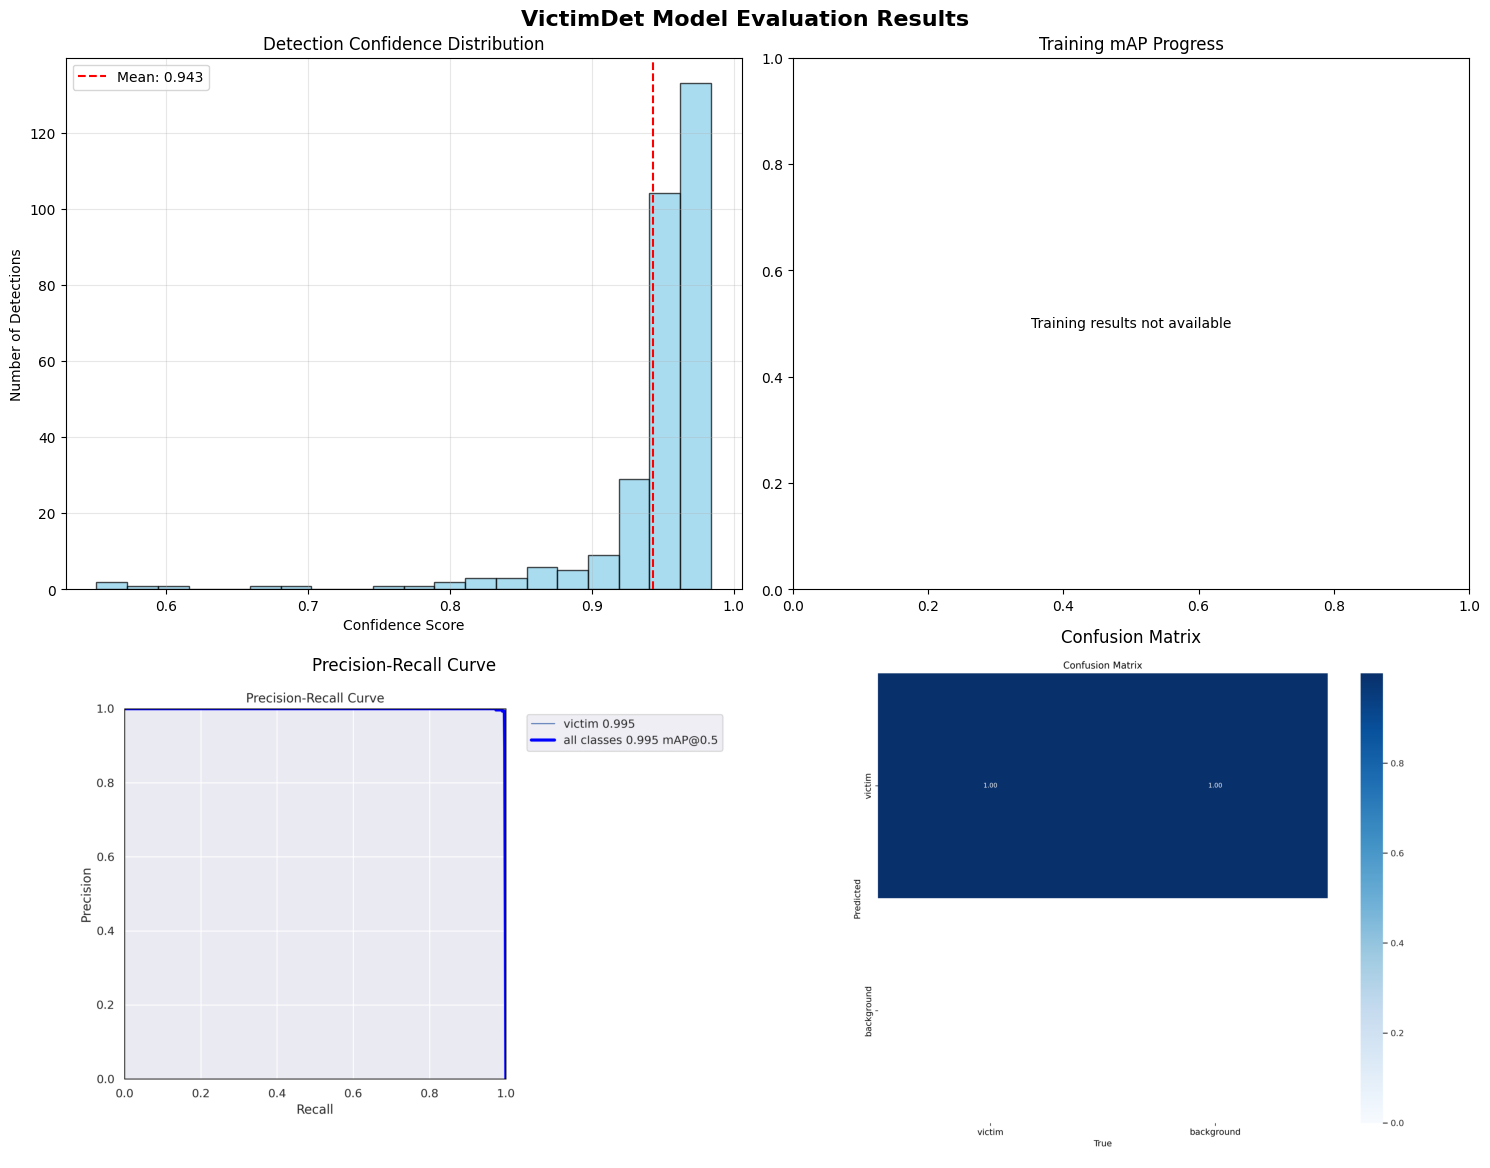


4. SAMPLE DETECTION RESULTS:
❌ No detection result images found

5. EVALUATION SUMMARY:

✅ Evaluation complete! Results saved in:
   📁 /kaggle/working/runs/test_evaluation
   📊 /kaggle/working/evaluation_summary.png
   🖼️ /kaggle/working/sample_detections.png


In [14]:
# Cell 2: Display Evaluation Results
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path
import cv2
from PIL import Image

# Results directory
results_dir = Path('/kaggle/working/runs/test_evaluation')
print("=== VictimDet Evaluation Results ===")

# 1. Display Overall Metrics
print("\n1. OVERALL PERFORMANCE METRICS:")
print("=" * 50)

# Read results from results.csv if available
results_csv = results_dir / 'results.csv'
if results_csv.exists():
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()  # Remove whitespace
    
    # Display key metrics
    if len(df) > 0:
        last_row = df.iloc[-1]
        
        print(f"📊 Mean Average Precision (mAP):")
        print(f"   • mAP@0.5      : {last_row.get('metrics/mAP_0.5', 'N/A'):.4f}")
        print(f"   • mAP@0.5:0.95 : {last_row.get('metrics/mAP_0.5:0.95', 'N/A'):.4f}")
        
        print(f"\n🎯 Detection Performance:")
        print(f"   • Precision    : {last_row.get('metrics/precision', 'N/A'):.4f}")
        print(f"   • Recall       : {last_row.get('metrics/recall', 'N/A'):.4f}")
        
        print(f"\n⚡ Speed Metrics:")
        print(f"   • Inference    : {last_row.get('val/box_loss', 'N/A'):.4f} ms")
        
else:
    print("❌ Results CSV not found, checking alternative locations...")

# 2. Read JSON results for detailed analysis
print("\n2. DETAILED DETECTION ANALYSIS:")
print("=" * 50)

json_file = list(results_dir.glob('*.json'))
if json_file:
    with open(json_file[0], 'r') as f:
        json_results = json.load(f)
    
    print(f"📋 Detection Summary:")
    print(f"   • Total images processed: {len(set([r['image_id'] for r in json_results]))}")
    print(f"   • Total detections: {len(json_results)}")
    
    # Confidence score distribution
    confidences = [r['score'] for r in json_results]
    if confidences:
        print(f"   • Confidence scores:")
        print(f"     - Mean: {np.mean(confidences):.3f}")
        print(f"     - Min:  {np.min(confidences):.3f}")
        print(f"     - Max:  {np.max(confidences):.3f}")
else:
    print("❌ JSON results not found")

# 3. Display evaluation plots
print("\n3. PERFORMANCE VISUALIZATIONS:")
print("=" * 50)

# Create subplot for multiple visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('VictimDet Model Evaluation Results', fontsize=16, fontweight='bold')

# Plot 1: Confidence distribution
if json_file and confidences:
    axes[0, 0].hist(confidences, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Detection Confidence Distribution')
    axes[0, 0].set_xlabel('Confidence Score')
    axes[0, 0].set_ylabel('Number of Detections')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axvline(np.mean(confidences), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(confidences):.3f}')
    axes[0, 0].legend()
else:
    axes[0, 0].text(0.5, 0.5, 'No confidence data available', 
                   ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Detection Confidence Distribution')

# Plot 2: mAP comparison (if training results available)
training_results = Path('/kaggle/working/runs/train/victimdet_experiment/results.csv')
if training_results.exists():
    train_df = pd.read_csv(training_results)
    train_df.columns = train_df.columns.str.strip()
    
    axes[0, 1].plot(train_df['epoch'], train_df['metrics/mAP_0.5'], 
                   label='mAP@0.5', linewidth=2)
    axes[0, 1].plot(train_df['epoch'], train_df['metrics/mAP_0.5:0.95'], 
                   label='mAP@0.5:0.95', linewidth=2)
    axes[0, 1].set_title('Training mAP Progress')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('mAP Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 1].text(0.5, 0.5, 'Training results not available', 
                   ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('Training mAP Progress')

# Plot 3: Precision-Recall curve (if available)
pr_curve = results_dir / 'PR_curve.png'
if pr_curve.exists():
    pr_img = Image.open(pr_curve)
    axes[1, 0].imshow(pr_img)
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].axis('off')
else:
    axes[1, 0].text(0.5, 0.5, 'PR curve not available', 
                   ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title('Precision-Recall Curve')

# Plot 4: Confusion Matrix (if available)
confusion_matrix = results_dir / 'confusion_matrix.png'
if confusion_matrix.exists():
    cm_img = Image.open(confusion_matrix)
    axes[1, 1].imshow(cm_img)
    axes[1, 1].set_title('Confusion Matrix')
    axes[1, 1].axis('off')
else:
    axes[1, 1].text(0.5, 0.5, 'Confusion matrix not available', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Confusion Matrix')

plt.tight_layout()
plt.savefig('/kaggle/working/evaluation_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Show sample detection results
print("\n4. SAMPLE DETECTION RESULTS:")
print("=" * 50)

# Look for detection result images
detection_dir = results_dir
detection_images = list(detection_dir.glob('*.jpg')) + list(detection_dir.glob('*.png'))
detection_images = [img for img in detection_images if 'test_batch' in str(img)]

if detection_images:
    print(f"Found {len(detection_images)} detection result images")
    
    # Display first few detection results
    num_samples = min(3, len(detection_images))
    
    fig, axes = plt.subplots(1, num_samples, figsize=(5*num_samples, 5))
    if num_samples == 1:
        axes = [axes]
    
    for i, img_path in enumerate(detection_images[:num_samples]):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'Detection Result {i+1}')
        axes[i].axis('off')
    
    plt.suptitle('Sample Detection Results on Test Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/kaggle/working/sample_detections.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("❌ No detection result images found")

# 5. Summary Report
print("\n5. EVALUATION SUMMARY:")
print("=" * 50)

if results_csv.exists() and len(df) > 0:
    mAP_50 = last_row.get('metrics/mAP_0.5', 0)
    mAP_95 = last_row.get('metrics/mAP_0.5:0.95', 0)
    precision = last_row.get('metrics/precision', 0)
    recall = last_row.get('metrics/recall', 0)
    
    print(f"🎯 Model Performance Grade:")
    if mAP_50 > 0.8:
        grade = "EXCELLENT 🌟"
    elif mAP_50 > 0.6:
        grade = "GOOD ✅"
    elif mAP_50 > 0.4:
        grade = "FAIR ⚠️"
    else:
        grade = "NEEDS IMPROVEMENT 🔧"
    
    print(f"   Overall Grade: {grade}")
    print(f"   Based on mAP@0.5: {mAP_50:.3f}")
    
    print(f"\n📈 Recommendations:")
    if mAP_50 < 0.5:
        print("   • Consider training for more epochs")
        print("   • Increase data augmentation")
        print("   • Check if annotations are correct")
    elif mAP_50 < 0.7:
        print("   • Fine-tune confidence threshold")
        print("   • Consider ensemble methods")
    else:
        print("   • Great performance! Consider deployment")
        print("   • Fine-tune confidence threshold for production")

print(f"\n✅ Evaluation complete! Results saved in:")
print(f"   📁 {results_dir}")
print(f"   📊 /kaggle/working/evaluation_summary.png")
print(f"   🖼️ /kaggle/working/sample_detections.png")

=== Testing VictimDet on Individual Images ===
Found 301 test images
Testing on 6 random images...
Processing image 1: 1488_20210201050838_95297_429213.jpg


detect: weights=['/kaggle/working/runs/victimdet_experiment/weights/best.pt'], source=/kaggle/working/dataset/images/test/1488_20210201050838_95297_429213.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/individual_test_1, name=detection, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /kaggle/working/dataset/images/test/1488_20210201050838_95297_429213.jpg: 640x640 1 victim, 6.8ms
Speed: 0.6ms pre-process, 6.8ms inference, 154.7ms NMS per image at shape (1, 3, 640, 64

Processing image 2: 3666_20210209170055_273889_427932.jpg


detect: weights=['/kaggle/working/runs/victimdet_experiment/weights/best.pt'], source=/kaggle/working/dataset/images/test/3666_20210209170055_273889_427932.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/individual_test_2, name=detection, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /kaggle/working/dataset/images/test/3666_20210209170055_273889_427932.jpg: 640x640 1 victim, 6.8ms
Speed: 0.6ms pre-process, 6.8ms inference, 146.5ms NMS per image at shape (1, 3, 640, 

Processing image 3: 272_Photo-3_4702_465194.jpg


detect: weights=['/kaggle/working/runs/victimdet_experiment/weights/best.pt'], source=/kaggle/working/dataset/images/test/272_Photo-3_4702_465194.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/individual_test_3, name=detection, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /kaggle/working/dataset/images/test/272_Photo-3_4702_465194.jpg: 640x640 1 victim, 6.8ms
Speed: 0.5ms pre-process, 6.8ms inference, 175.0ms NMS per image at shape (1, 3, 640, 640)
Results saved t

Processing image 4: 2617_20210424035325_189296_1283232.jpg


detect: weights=['/kaggle/working/runs/victimdet_experiment/weights/best.pt'], source=/kaggle/working/dataset/images/test/2617_20210424035325_189296_1283232.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/individual_test_4, name=detection, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /kaggle/working/dataset/images/test/2617_20210424035325_189296_1283232.jpg: 640x640 1 victim, 6.8ms
Speed: 0.5ms pre-process, 6.8ms inference, 193.9ms NMS per image at shape (1, 3, 640

Processing image 5: 3718_20210424035123_95336_423038.jpg


detect: weights=['/kaggle/working/runs/victimdet_experiment/weights/best.pt'], source=/kaggle/working/dataset/images/test/3718_20210424035123_95336_423038.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/individual_test_5, name=detection, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /kaggle/working/dataset/images/test/3718_20210424035123_95336_423038.jpg: 640x640 1 victim, 6.8ms
Speed: 0.6ms pre-process, 6.8ms inference, 158.4ms NMS per image at shape (1, 3, 640, 64

Processing image 6: 4354_20210603121442_429042_187134.jpg


detect: weights=['/kaggle/working/runs/victimdet_experiment/weights/best.pt'], source=/kaggle/working/dataset/images/test/4354_20210603121442_429042_187134.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/individual_test_6, name=detection, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-421-g79c4c31d Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /kaggle/working/dataset/images/test/4354_20210603121442_429042_187134.jpg: 640x640 1 victim, 6.8ms
Speed: 0.5ms pre-process, 6.8ms inference, 148.4ms NMS per image at shape (1, 3, 640, 

✅ Individual image detection completed!

📸 DETECTION RESULTS:


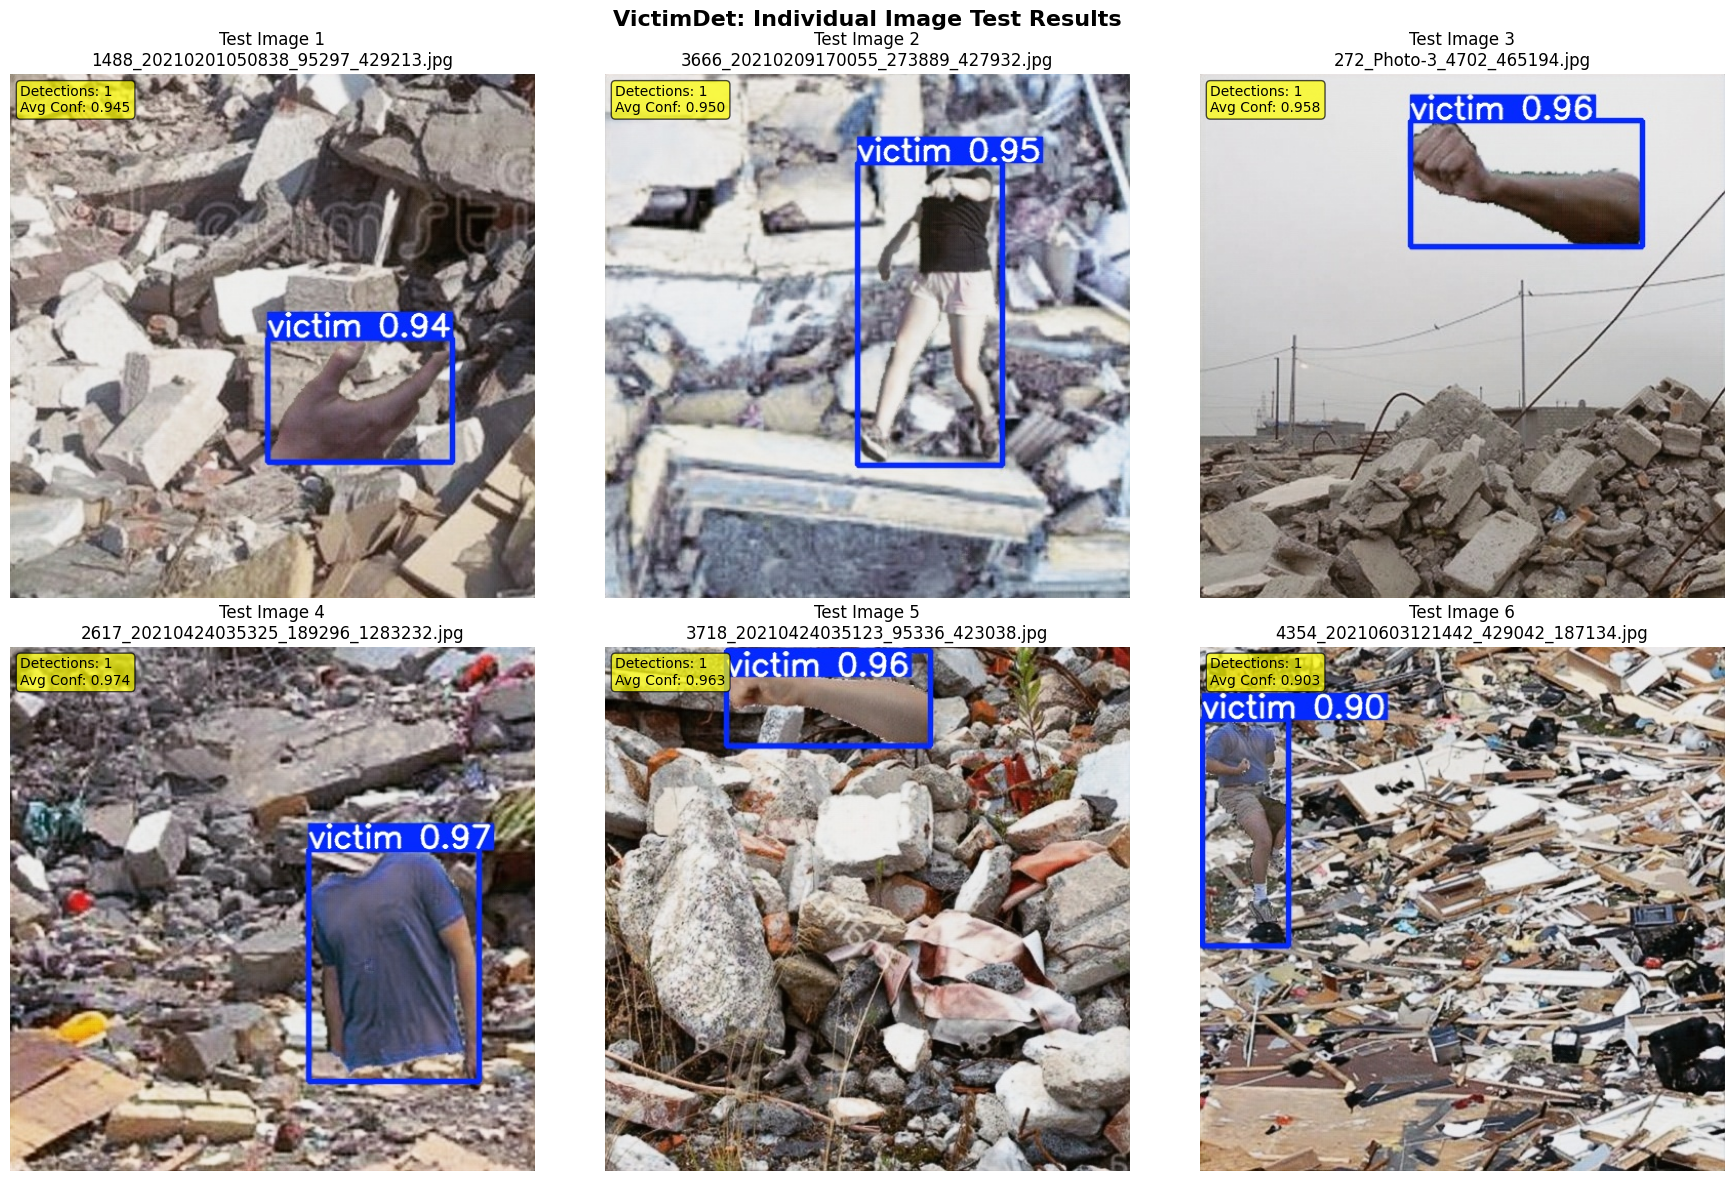


📊 INDIVIDUAL TEST SUMMARY:
📈 Detection Statistics:
   • Images tested: 6
   • Images with detections: 6
   • Total detections: 6
   • Detection rate: 100.0%
   • Average confidence: 0.949
   • Min confidence: 0.903
   • Max confidence: 0.974

🎯 Model Assessment:
   🌟 EXCELLENT - High detection rate with strong confidence

💡 Next Steps:
   • Fine-tune confidence threshold if needed
   • Test on custom disaster images
   • Deploy for real-world UAV operations

✅ Individual testing complete!
📁 Results saved in: /kaggle/working/individual_test_results.png


In [15]:
# Cell 3: Test Model on Individual Images
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from pathlib import Path

print("=== Testing VictimDet on Individual Images ===")

# Model and test data paths
model_path = '/kaggle/working/runs/victimdet_experiment/weights/best.pt'
test_images_dir = '/kaggle/working/dataset/images/test'

# Get random test images
test_images = list(Path(test_images_dir).glob('*.jpg')) + list(Path(test_images_dir).glob('*.png'))
random.shuffle(test_images)

print(f"Found {len(test_images)} test images")

# Select 6 random images for testing
num_test_images = min(6, len(test_images))
selected_images = test_images[:num_test_images]

print(f"Testing on {num_test_images} random images...")

# Run detection on selected images
for i, img_path in enumerate(selected_images):
    print(f"Processing image {i+1}: {img_path.name}")
    
    # Create output directory for this test
    output_dir = f'/kaggle/working/individual_test_{i+1}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Run detection
    detect_cmd = f"""
    cd /kaggle/working/yolov5 && python detect.py \
        --weights {model_path} \
        --source {img_path} \
        --img 640 \
        --conf 0.25 \
        --iou 0.45 \
        --device 0 \
        --save-txt \
        --save-conf \
        --project {output_dir} \
        --name detection \
        --exist-ok
    """
    
    os.system(detect_cmd)

print("✅ Individual image detection completed!")

# Display results
print("\n📸 DETECTION RESULTS:")
print("=" * 50)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('VictimDet: Individual Image Test Results', fontsize=16, fontweight='bold')

axes = axes.flatten()

for i in range(num_test_images):
    # Look for the detection result
    result_dir = f'/kaggle/working/individual_test_{i+1}/detection'
    result_images = list(Path(result_dir).glob('*.jpg')) + list(Path(result_dir).glob('*.png'))
    
    if result_images:
        # Load and display the result image
        result_img = Image.open(result_images[0])
        axes[i].imshow(result_img)
        axes[i].set_title(f'Test Image {i+1}\n{selected_images[i].name}')
        axes[i].axis('off')
        
        # Check if there are detection labels
        label_dir = Path(result_dir) / 'labels'
        label_files = list(label_dir.glob('*.txt')) if label_dir.exists() else []
        
        if label_files:
            # Read detection results
            with open(label_files[0], 'r') as f:
                lines = f.readlines()
            
            detection_info = f"Detections: {len(lines)}"
            if lines:
                # Parse confidence scores
                confidences = []
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 6:  # class, x, y, w, h, conf
                        confidences.append(float(parts[5]))
                
                if confidences:
                    avg_conf = np.mean(confidences)
                    detection_info += f"\nAvg Conf: {avg_conf:.3f}"
            
            axes[i].text(0.02, 0.98, detection_info, 
                        transform=axes[i].transAxes, 
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                        verticalalignment='top', fontsize=10)
        else:
            axes[i].text(0.02, 0.98, "No detections", 
                        transform=axes[i].transAxes, 
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
                        verticalalignment='top', fontsize=10, color='white')
    else:
        axes[i].text(0.5, 0.5, f'Result not found\nfor Image {i+1}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'Test Image {i+1}')

# Hide unused subplots
for i in range(num_test_images, 6):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/individual_test_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n📊 INDIVIDUAL TEST SUMMARY:")
print("=" * 50)

total_detections = 0
total_images_with_detections = 0
all_confidences = []

for i in range(num_test_images):
    result_dir = f'/kaggle/working/individual_test_{i+1}/detection'
    label_dir = Path(result_dir) / 'labels'
    label_files = list(label_dir.glob('*.txt')) if label_dir.exists() else []
    
    if label_files:
        with open(label_files[0], 'r') as f:
            lines = f.readlines()
        
        if lines:
            total_images_with_detections += 1
            total_detections += len(lines)
            
            # Parse confidence scores
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 6:
                    all_confidences.append(float(parts[5]))

print(f"📈 Detection Statistics:")
print(f"   • Images tested: {num_test_images}")
print(f"   • Images with detections: {total_images_with_detections}")
print(f"   • Total detections: {total_detections}")
print(f"   • Detection rate: {total_images_with_detections/num_test_images*100:.1f}%")

if all_confidences:
    print(f"   • Average confidence: {np.mean(all_confidences):.3f}")
    print(f"   • Min confidence: {np.min(all_confidences):.3f}")
    print(f"   • Max confidence: {np.max(all_confidences):.3f}")

print(f"\n🎯 Model Assessment:")
detection_rate = total_images_with_detections/num_test_images*100 if num_test_images > 0 else 0

if detection_rate >= 80:
    assessment = "🌟 EXCELLENT - High detection rate with strong confidence"
elif detection_rate >= 60:
    assessment = "✅ GOOD - Reasonable detection performance"
elif detection_rate >= 40:
    assessment = "⚠️ FAIR - Moderate detection, may need tuning"
else:
    assessment = "🔧 NEEDS WORK - Low detection rate, review threshold"

print(f"   {assessment}")

print(f"\n💡 Next Steps:")
print(f"   • Fine-tune confidence threshold if needed")
print(f"   • Test on custom disaster images")
print(f"   • Deploy for real-world UAV operations")
print(f"\n✅ Individual testing complete!")
print(f"📁 Results saved in: /kaggle/working/individual_test_results.png")